1. Loading the IOT-DH Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv('IoT-DH Dataset.csv')

print("Dataset shape:", df.shape)
print("\nColumn information:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique values in 'label' column:")
print(df['label'].value_counts(dropna=False))

Dataset shape: (15817209, 23)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15817209 entries, 0 to 15817208
Data columns (total 23 columns):
 #   Column       Dtype  
---  ------       -----  
 0   dt           float64
 1   switch       int64  
 2   src          object 
 3   dst          object 
 4   pktcount     int64  
 5   bytecount    int64  
 6   dur          float64
 7   dur_nsec     int64  
 8   tot_dur      float64
 9   flows        int64  
 10  packetins    int64  
 11  pktperflow   float64
 12  byteperflow  float64
 13  pktrate      float64
 14  Pairflow     int64  
 15  Protocol     object 
 16  port_no      int64  
 17  tx_bytes     int64  
 18  rx_bytes     int64  
 19  tx_kbps      float64
 20  rx_kbps      float64
 21  tot_kbps     float64
 22  label        float64
dtypes: float64(10), int64(10), object(3)
memory usage: 2.7+ GB
None

Missing values:
dt                    0
switch                0
src                   0
dst                   0
pk

2. Data Preprocessing

a. Handling missing values

In [2]:
df_clean = df.dropna(subset=['label'])
print("Shape after removing rows with missing labels:", df_clean.shape)
df_clean.head()

Shape after removing rows with missing labels: (104345, 23)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425.0,1,10.0.0.1,10.0.0.8,45304,48294064,100.0,716000000,1.010000e+11,3,...,451.0,0,UDP,3,143928631,3917,0.0,0.0,0.0,0.0
1,11605.0,1,10.0.0.1,10.0.0.8,126395,134737070,280.0,734000000,2.810000e+11,2,...,451.0,0,UDP,4,3842,3520,0.0,0.0,0.0,0.0
2,11425.0,1,10.0.0.2,10.0.0.8,90333,96294978,200.0,744000000,2.010000e+11,3,...,451.0,0,UDP,1,3795,1242,0.0,0.0,0.0,0.0
3,11425.0,1,10.0.0.2,10.0.0.8,90333,96294978,200.0,744000000,2.010000e+11,3,...,451.0,0,UDP,2,3688,1492,0.0,0.0,0.0,0.0
4,11425.0,1,10.0.0.2,10.0.0.8,90333,96294978,200.0,744000000,2.010000e+11,3,...,451.0,0,UDP,3,3413,3665,0.0,0.0,0.0,0.0


b. NaN values in 'rx_kbps' and 'tot_kbps' columns are filled with mean values

In [3]:
df_clean.loc[:, 'rx_kbps'] = df_clean['rx_kbps'].fillna(df_clean['rx_kbps'].mean())
df_clean.loc[:, 'tot_kbps'] = df_clean['tot_kbps'].fillna(df_clean['tot_kbps'].mean())
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  float64
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  float64
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  float64
 12  byteperflow  104345 non-null  float64
 13  pktrate      104345 non-null  float64
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-null 


Class distribution:
label
0.0    0.609143
1.0    0.390857
Name: proportion, dtype: float64


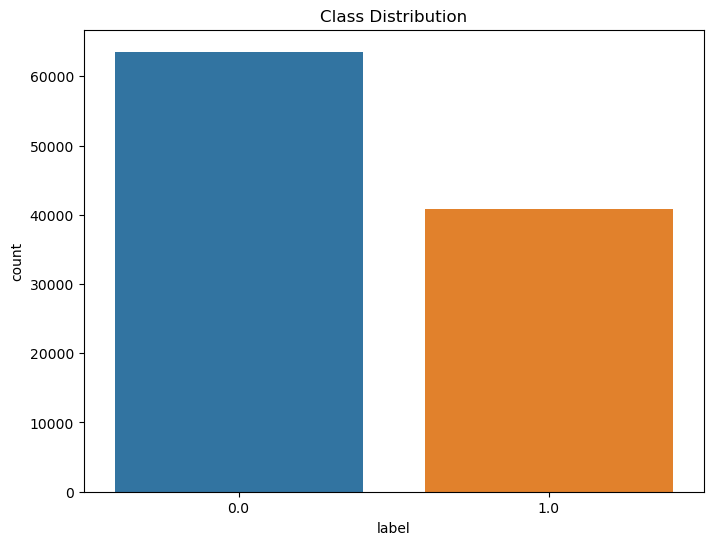

Text(0.5, 1.0, 'Correlation Heatmap')

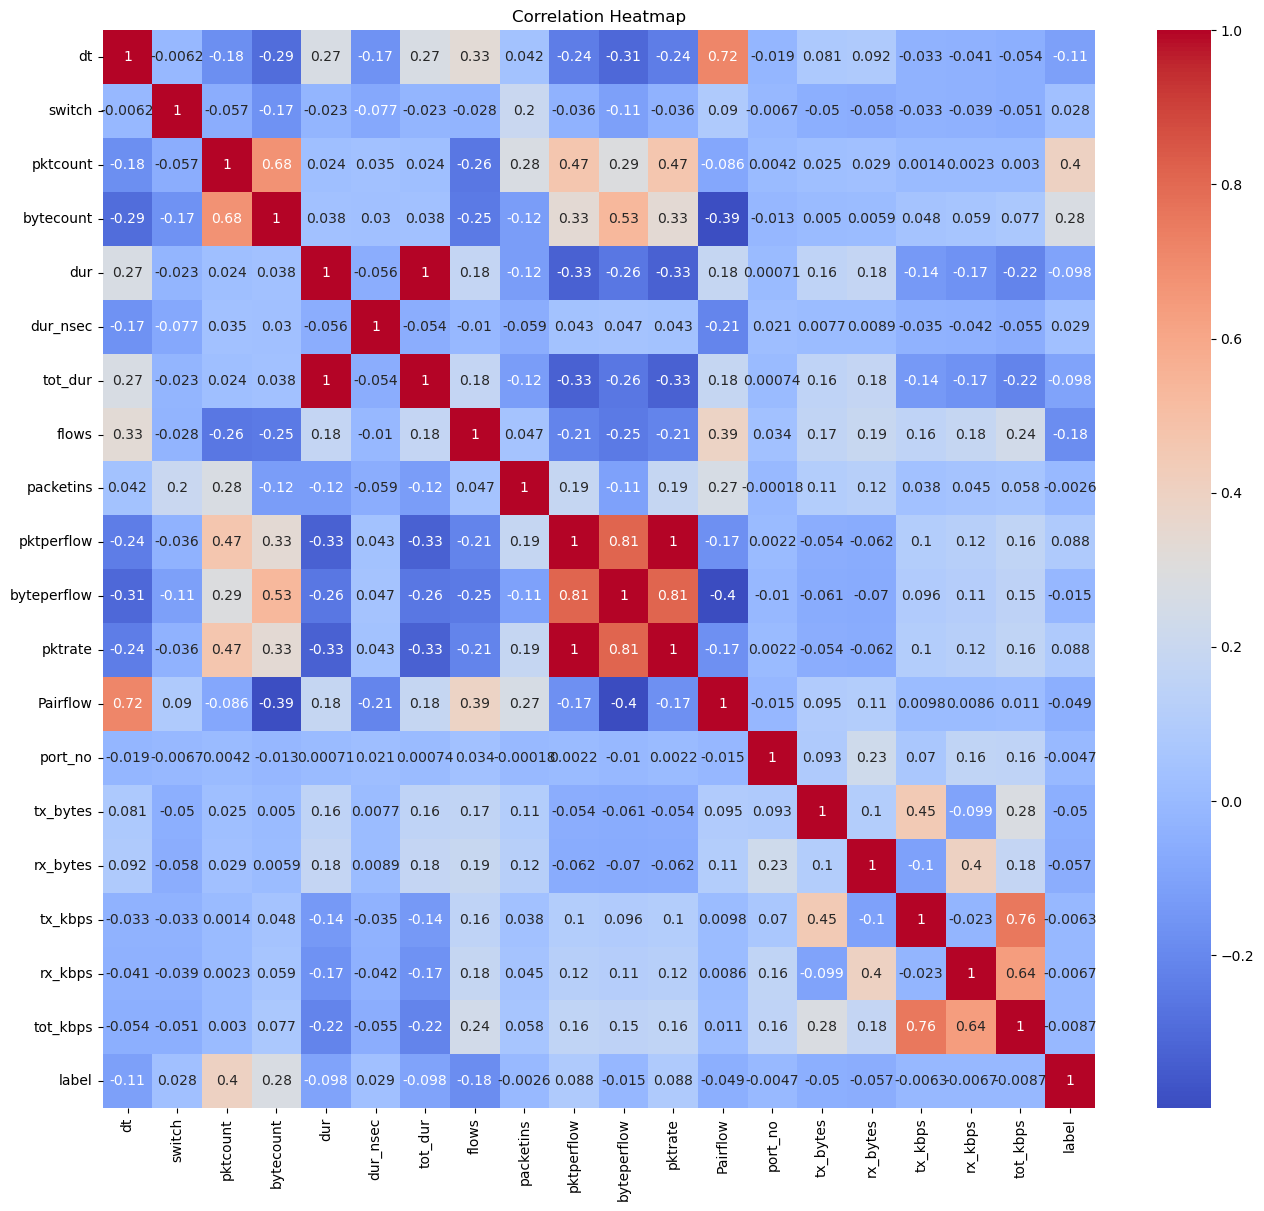

In [4]:
# Checking the class distribution
print("\nClass distribution:")
print(df_clean['label'].value_counts(normalize=True))

# Visualizing the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_clean)
plt.title('Class Distribution')
plt.show()
df_mat=df_clean.select_dtypes(exclude=['object'])

# Correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df_mat.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [5]:
# Selecting the 10 most relevant features.
features = ['dt', 'dur', 'dur_nsec', 'tot_dur', 'pktrate', 'Protocol', 'port_no', 'tx_kbps', 'rx_kbps', 'tot_kbps']
X = df_clean[features].copy()
y = df_clean['label']
print("Features selected:", X.columns)

Features selected: Index(['dt', 'dur', 'dur_nsec', 'tot_dur', 'pktrate', 'Protocol', 'port_no',
       'tx_kbps', 'rx_kbps', 'tot_kbps'],
      dtype='object')


c. Label Encoding categorical features

In [6]:
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column])
print("Encoded categorical features.")

Encoded categorical features.


In [7]:
print(f"\nColumn: {column}")
print("Original unique values:", df_clean[column].unique())
print("Transformed unique values:", X[column].unique())

value_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Value mapping:")
for original, transformed in value_mapping.items():
    print(f"{original} -> {transformed}")


Column: Protocol
Original unique values: ['UDP' 'TCP' 'ICMP']
Transformed unique values: [2 1 0]
Value mapping:
ICMP -> 0
TCP -> 1
UDP -> 2


d. Feaure Scaling

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

e. Class Balancing

Data shape after SMOTE: (127122, 10)
Class distribution after SMOTE:
label
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


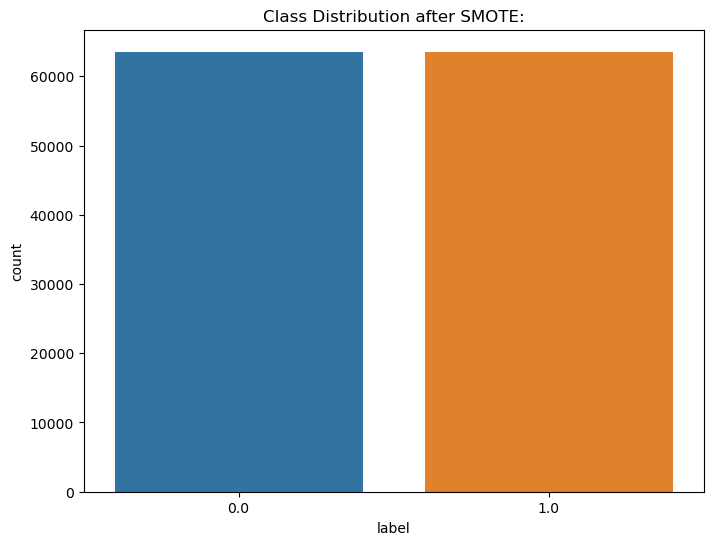

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("Data shape after SMOTE:", X_resampled.shape)
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, data=df_clean)
plt.title('Class Distribution after SMOTE:')
plt.show()

3. Feature Selection

In [10]:
selector = SelectKBest(f_classif, k=8)
X_selected = selector.fit_transform(X_resampled, y_resampled)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['dt', 'dur', 'dur_nsec', 'tot_dur', 'pktrate', 'Protocol', 'rx_kbps',
       'tot_kbps'],
      dtype='object')


In [11]:
db_f=pd.DataFrame(X_resampled, columns=features)[selected_features].corr()

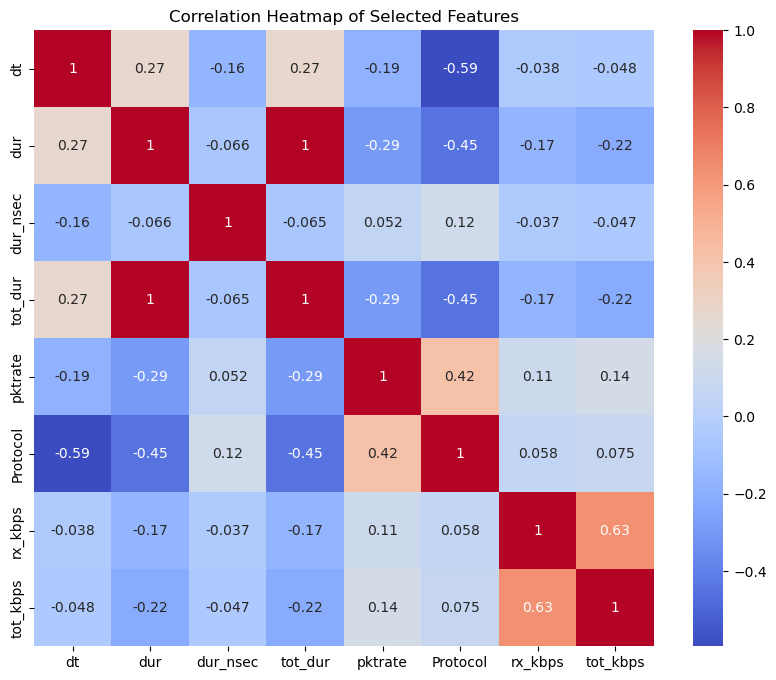

In [12]:
# Correlation heatmap for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(db_f, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

4. Splitting the dataset into training and test set (80:20)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (101697, 8)
Test set size: (25425, 8)


5. Model Training and Hyperparameter Tuning

The hyperparameter selection was generated with assistance from Perplexity
Reference: Perplexity AI. (2024). Perplexity [Pro Search Model]. perplexity.ai

a. Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Random Forest Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12758
         1.0       1.00      1.00      1.00     12667

    accuracy                           1.00     25425
   macro avg       1.00      1.00      1.00     25425
weighted avg       1.00      1.00      1.00     25425



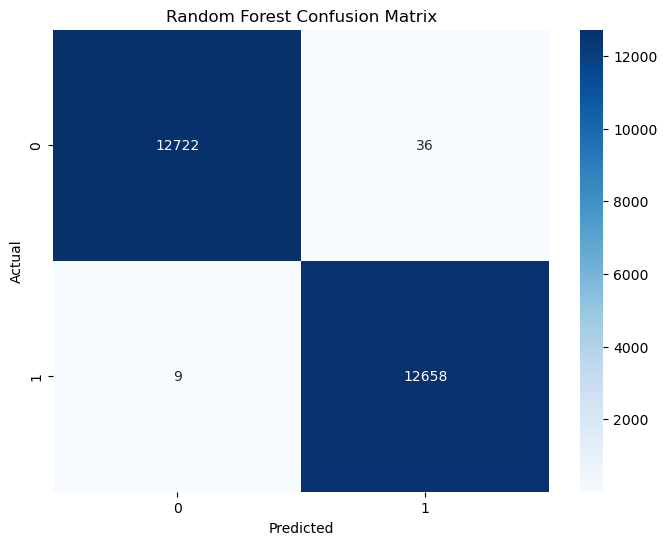

In [15]:
# Random Forest Model with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
cv_rf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
rf_random_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=cv_rf, n_jobs=-1, random_state=42,verbose=1)
rf_random_search.fit(X_train, y_train)

print("\nRandom Forest Best parameters:", rf_random_search.best_params_)
rf_best_model = rf_random_search.best_estimator_

X_test_np = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else np.array(X_test)
rf_y_pred = rf_best_model.predict(X_test_np)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

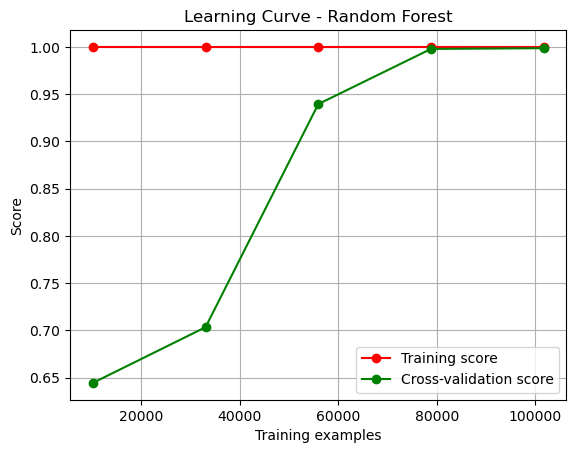

In [16]:
# Learning Curve for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_best_model, X_selected, y_resampled,
                                                        cv=cv_rf, n_jobs=-1,
                                                        train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean,'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

b. K-Nearest Neighbors

E:\My-softwares\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits

KNN Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}

KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     12758
         1.0       0.99      0.99      0.99     12667

    accuracy                           0.99     25425
   macro avg       0.99      0.99      0.99     25425
weighted avg       0.99      0.99      0.99     25425



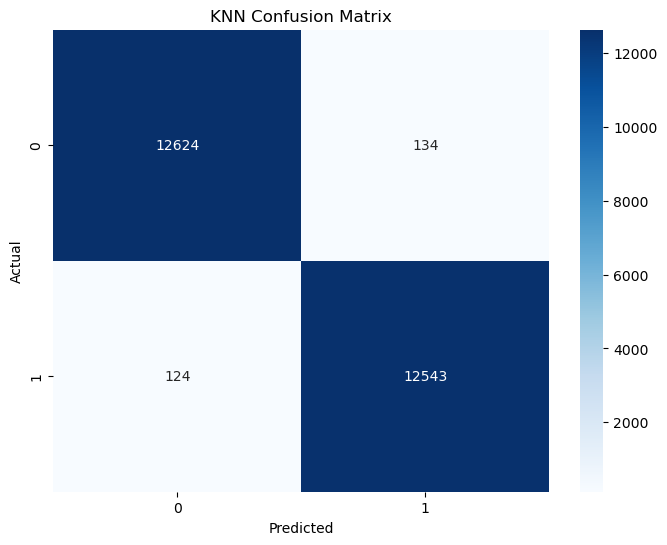

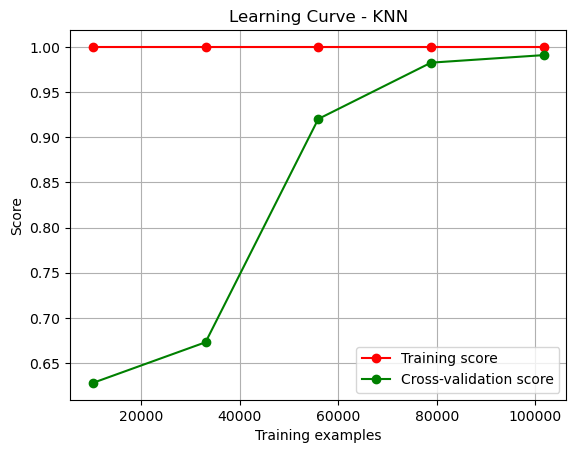

In [17]:
# KNN Model with hyperparameter tuning
knn_param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
cv_knn = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
rf_random_search = RandomizedSearchCV(knn, knn_param_grid, n_iter=20,cv=cv_knn,n_jobs=-1, random_state=42,verbose=1)
rf_random_search.fit(X_train, y_train)

print("\nKNN Best parameters:", rf_random_search.best_params_)
knn_best_model = rf_random_search.best_estimator_

knn_y_pred = knn_best_model.predict(X_test)
print("\nKNN Classification Report:")
print(classification_report(y_test, knn_y_pred))

plt.figure(figsize=(8 ,6))
sns.heatmap(confusion_matrix(y_test ,knn_y_pred), annot=True ,fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Learning Curve for KNN
train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(knn_best_model,X_selected,y_resampled,
                                                                    cv=cv_knn,n_jobs=-1,train_sizes=np.linspace(.1,1.0,5))
train_scores_mean_knn = np.mean(train_scores_knn,
                                axis=1)
test_scores_mean_knn = np.mean(test_scores_knn,
                               axis=1)

plt.figure()
plt.title("Learning Curve - KNN")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.plot(train_sizes_knn,
         train_scores_mean_knn,
         'o-',
         color="r",
         label="Training score")
plt.plot(train_sizes_knn,
         test_scores_mean_knn,
         'o-',
         color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

c. Naive Bayes


Naive Bayes Best parameters: {'var_smoothing': 0.657933224657568}

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.60     12758
         1.0       0.61      0.70      0.65     12667

    accuracy                           0.63     25425
   macro avg       0.63      0.63      0.62     25425
weighted avg       0.63      0.63      0.62     25425



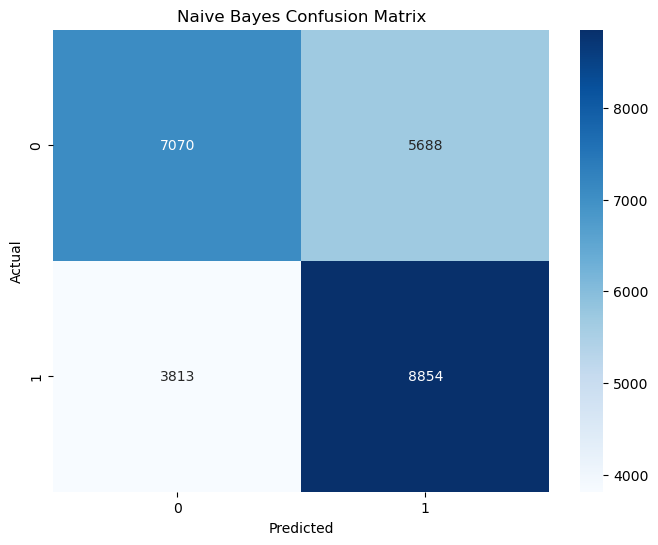

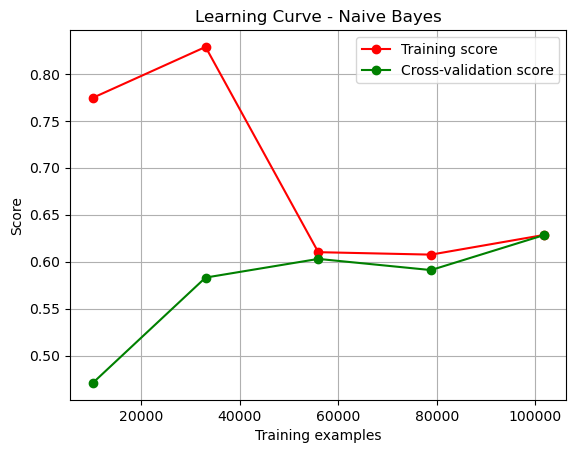

In [18]:
# Naive Bayes Model with hyperparameter tuning
nb_param_grid={'var_smoothing':np.logspace(0,-9,num=100)}
nb=GaussianNB()
cv_nb=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
nb_grid_search=GridSearchCV(nb ,nb_param_grid ,cv=cv_nb , n_jobs=-1)
nb_grid_search.fit(X_train ,y_train)

print("\nNaive Bayes Best parameters:",nb_grid_search.best_params_)
nb_best_model=nb_grid_search.best_estimator_

nb_y_pred=nb_best_model.predict(X_test)
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test ,nb_y_pred))

plt.figure(figsize=(8 ,6))
sns.heatmap(confusion_matrix(y_test ,nb_y_pred), annot=True ,fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Learning Curve for Naive Bayes

train_sizes_nb ,train_scores_nb ,test_scores_nb=learning_curve(nb_best_model ,
                                                               X_selected ,
                                                               y_resampled ,
                                                               cv=cv_nb ,
                                                               n_jobs=-1 ,
                                                               train_sizes=np.linspace(.1 ,
                                                                                       1.0 ,
                                                                                       5))
train_scores_mean_nb=np.mean(train_scores_nb ,
                             axis=1)
test_scores_mean_nb=np.mean(test_scores_nb ,
                            axis=1)

plt.figure()
plt.title("Learning Curve - Naive Bayes")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.plot(train_sizes_nb ,
         train_scores_mean_nb ,
         'o-' ,
         color="r",
         label="Training score")
plt.plot(train_sizes_nb ,
         test_scores_mean_nb ,
         'o-' ,
         color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

6. Model Persitence (Saving the model)

In [19]:
joblib.dump(rf_best_model ,'rf_model.joblib')
joblib.dump(nb_best_model ,'nb_model.joblib')
joblib.dump(knn_best_model ,'knn_model.joblib')
joblib.dump(scaler ,'scaler.joblib')
joblib.dump(selector ,'feature_selector.joblib')
print("\Models and preprocessing tools saved.")

\Models and preprocessing tools saved.


7. Testing on custom input

In [54]:
db_input = X.iloc[0:0].copy()

In [55]:
n = int(input("Enter number of records: "))
for i in range(n):
    record = []
    for col in db_input.columns:
        value = input(f"Enter {col}: ")
        record.append(value)
    db_input.loc[len(db_input)]= record

Enter number of records: 1
Enter dt: 11635.0
Enter dur: 310.0
Enter dur_nsec: 738000000.0
Enter tot_dur: 311000000000.0
Enter pktrate: 288.0
Enter Protocol: 2
Enter port_no: 3
Enter tx_kbps: 0.0
Enter rx_kbps: 0.0
Enter tot_kbps: 0.0


In [57]:
custom_scaled = scaler.transform(db_input)
custom_selected = selector.transform(custom_scaled)
rf_prediction=rf_best_model.predict(custom_selected)
nb_prediction=nb_best_model.predict(custom_selected)
knn_prediction=knn_best_model.predict(custom_selected)

print("\nPrediction for custom input (Random Forest):", rf_prediction)
print("Prediction for custom input (Naive Bayes):", nb_prediction)
print("Prediction for custom input (KNN):", knn_prediction)


Prediction for custom input (Random Forest): [1.]
Prediction for custom input (Naive Bayes): [1.]
Prediction for custom input (KNN): [1.]


In [ ]:
custom_data={
'dt': [11335.0],
'dur':[110.0],
'dur_nsec':[739000000],
'tot_dur':[111000000000.0],
'pktrate':[450.0],
'Protocol':[2],
'port_no':[2],
'tx_kbps':[0.0],
'rx_kbps':[6467.0],
'tot_kbps':[6467.0]
}
custom_data={
'dt': [11635.0],
'dur':[310.0],
'dur_nsec':[738000000],
'tot_dur':[311000000000.0],
'pktrate':[288.0],
'Protocol':[2],
'port_no':[3],
'tx_kbps':[0.0],
'rx_kbps':[0.0],
'tot_kbps':[0.0]
}
custom_data={
'dt': [10659.0],
'dur':[44.0],
'dur_nsec':[580000000],
'tot_dur':[44580000000.0],
'pktrate':[301.0],
'Protocol':[1],
'port_no':[2],
'tx_kbps':[140.0],
'rx_kbps':[131.0],
'tot_kbps':[271.0]
}